# Iterative transfer learning

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp
from tqdm.auto import tqdm

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.utils_plot import plot_loss_and_all_solution
from src.load_save import load_run_history
from src.transfer_learning import compute_H_and_dH_dt, analytically_compute_weights

from src.utils_plot import plot_transfer_learned_and_analytical

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [8]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Wed Feb 14 17:25:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              N/A /  20W |   1148MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

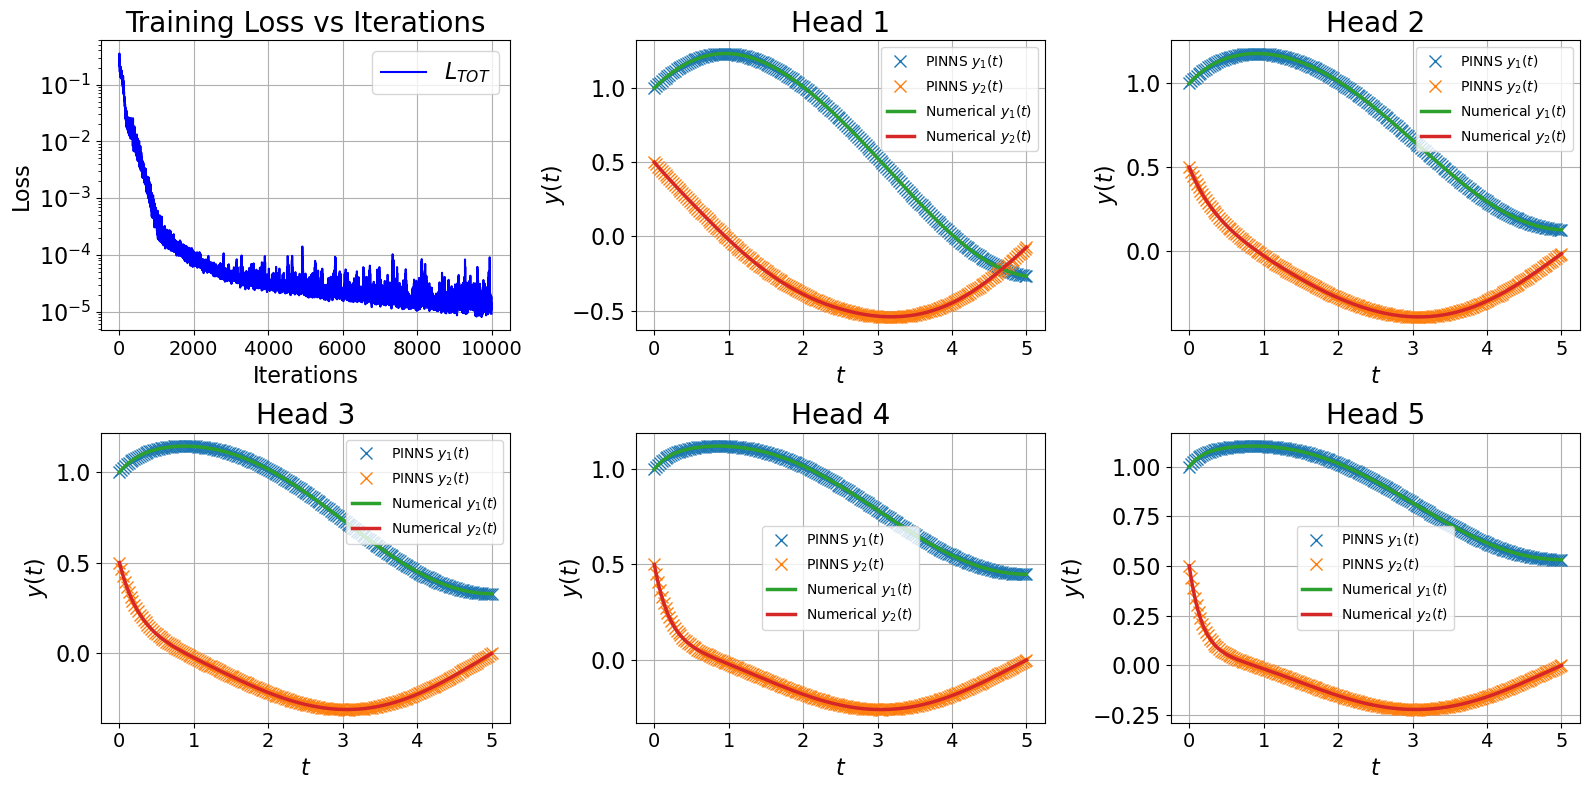

In [49]:
file_name = "nonlinear_repara_2141608"
equation_name = "duffing"

trained_model, \
x_range, \
iterations, \
hid_lay, \
num_equations, \
num_heads, \
loss_hist, \
alpha_list, \
A_list, \
IC_list, \
force_list = load_run_history(equation_name, file_name, dev, prev=False)

reparametrization=True
beta=0.5
def equation(t, y, alpha, beta=beta):
    if isinstance(y, torch.Tensor):
      yp = torch.zeros_like(y)
      force = torch.cos(t)
    elif isinstance(y, np.ndarray):
      yp = np.zeros_like(y)
      force = np.cos(t)
    yp[..., 0] = y[..., 1]
    yp[..., 1] = -0.1*y[..., 0] - alpha*y[..., 1] - beta*y[..., 0]**3 + force
    return yp
equation_list = [lambda t, y, Alpha=alpha: equation(t, y, Alpha) for alpha in alpha_list]

numerical_sol_fct = lambda x, v, alpha, beta: (solve_ivp(equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(alpha, beta), t_eval=x.squeeze(), method="Radau").y.T)
numerical_sol_list = [lambda x, IC=ic.detach().cpu().numpy(), Alpha=alpha, beta=beta: numerical_sol_fct(x, IC, Alpha, beta) for ic, alpha in zip(IC_list, alpha_list)]

plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_list,
                           trained_model=trained_model, v_list=IC_list,
                           A_list=None, force=None, train_losses=loss_hist,
                           device=dev, equation_list=equation_list,
                           reparametrization=reparametrization)

# Iterative transfer learning

In [50]:
from collections import defaultdict
import time
from tqdm.auto import trange
import torch.nn as nn

from src.loss import calc_loss_nonlinear


def transfer_learning(iterations, x_range, N, equation_transfer, IC, num_equations,
                      dev, hid_lay, pretrained_model, lr, optimizer_name,
                      decay=True, gamma=0.1, reparametrization=False, tqdm_bool=False):

    for i, pretrained_layer in enumerate(pretrained_model.hidden_layers):
        if isinstance(pretrained_layer, nn.Linear):
            for param in pretrained_layer.parameters():
                param.requires_grad = False  # Freeze the layer
    pretrained_model.multi_head_output = nn.ModuleList([nn.Linear(hid_lay[-1], num_equations)]).double()
    pretrained_model.multi_head_output[0].bias = None
    pretrained_model.n_heads = 1
    pretrained_model.to(dev)
    
    # set-up the optimizer
    if optimizer_name=="LBFGS":
        optimizer = torch.optim.LBFGS(pretrained_model.parameters(), history_size=100, max_iter=20, lr=lr)
    if optimizer_name=="Adam":
        optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=lr)

    # store loss and mse values
    loss_history = defaultdict(list)
    start_time = time.time()

    # training loop
    for i in trange(iterations) if tqdm_bool else range(iterations):

        rng = np.random.default_rng()
        x = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
        x = x[rng.choice(range(0, len(x)), size=N, replace=False)]
        x = x.reshape(-1, 1)
        x, _ = x.sort(dim=0)
        
        global curr_loss
        if optimizer_name=="LBFGS":
            def closure():
                optimizer.zero_grad()
                global curr_loss
                L, curr_loss = calc_loss_nonlinear(x, [equation_transfer], [IC], pretrained_model, numerical_solution=None, t_eval=None, device=dev, reparametrization=reparametrization)
                if (i % 1 == 0):
                    info_loss = f"Iterations {i}"
                    for k, v in curr_loss.items():
                        if k != "head":
                            info_loss += f", {k} = {v}"
                print(info_loss)
                L.backward(retain_graph=True)
                return L
            optimizer.step(closure)

        if optimizer_name == "Adam":
            _, curr_loss = calc_loss_nonlinear(x, [equation_transfer], [IC], pretrained_model, numerical_solution=None, t_eval=None, device=dev, reparametrization=reparametrization)
            if (i % 100 == 0):
                info_loss = f"Iterations {i}"
                for k, v in curr_loss.items():
                    if k != "head":
                        info_loss += f", {k} = {v}"
                print(info_loss)
            curr_loss['L_total'].backward()
            if decay:
                gamma = 0.95  # Adjust the decay factor accordingly
                every = 50  # Adjust the decay interval accordingly
                for param in pretrained_model.multi_head_output[0].parameters():
                    param.grad *= (gamma**((i + 1) / every))
            optimizer.step()
            optimizer.zero_grad()

        # store individual loss terms for plotting
        loss_history['L_IC'].append(curr_loss['L_IC'].detach().item())
        loss_history['L_ODE'].append(curr_loss['L_ODE'].detach().item())
        loss_history['L_total'].append(curr_loss['L_total'].detach().item())

    end_time = time.time()
    total_time = end_time - start_time
    return loss_history, pretrained_model, total_time

In [80]:
alpha_transfer = 50
#lr = 0.0001
lr=0.5

#iterations=1000
iterations=20

In [81]:
N=200
equation_transfer = lambda t, y, Alpha=alpha_transfer: equation(t, y, Alpha)
IC = IC_list[0]
loss_transfer, model_transfer, time_transfer = transfer_learning(iterations=iterations, x_range=x_range, N=N,
                                                                 equation_transfer=equation_transfer, IC=IC,
                                                                 num_equations=num_equations, dev=dev, hid_lay=hid_lay,
                                                                 pretrained_model=trained_model, lr=lr, optimizer_name="LBFGS",
                                                                 decay=False, gamma=0.1, reparametrization=reparametrization, tqdm_bool=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Iterations 0, L_total = 38.84284387402797, L_ODE = 38.84284387402797, L_IC = 0.0
Iterations 0, L_total = 23.1826048161624, L_ODE = 23.1826048161624, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 19.947330797873818, L_ODE = 19.947330797873818, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 18.09443989591146, L_ODE = 18.09443989591146, L_IC = 0.0
Iterations 0, L_total = 16.950420833865675, L_ODE = 16.950420833865675, L_IC = 0.0
Iterations 0, L_total = 16.20477213420191, L_ODE = 16.20477213420191, L_IC = 0.0
Iterations 0, L_total = 15.494256299471624, L_ODE = 15.494256299471624, L_IC = 0.0
Iterations 0, L_total = 14.418307321109587, L_ODE = 14.418307321109587, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 12.84569220869072, L_ODE = 12.84569220869072, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 10.886112104072755, L_ODE = 10.886112104072755, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 8.620690915452, L_ODE = 8.620690915452, L_IC = 0.0
Iterations 0, L_t

mean 0.28405020070427117
max 0.37603702548527806
mean 0.01590975380992285
max 0.2416480603332149


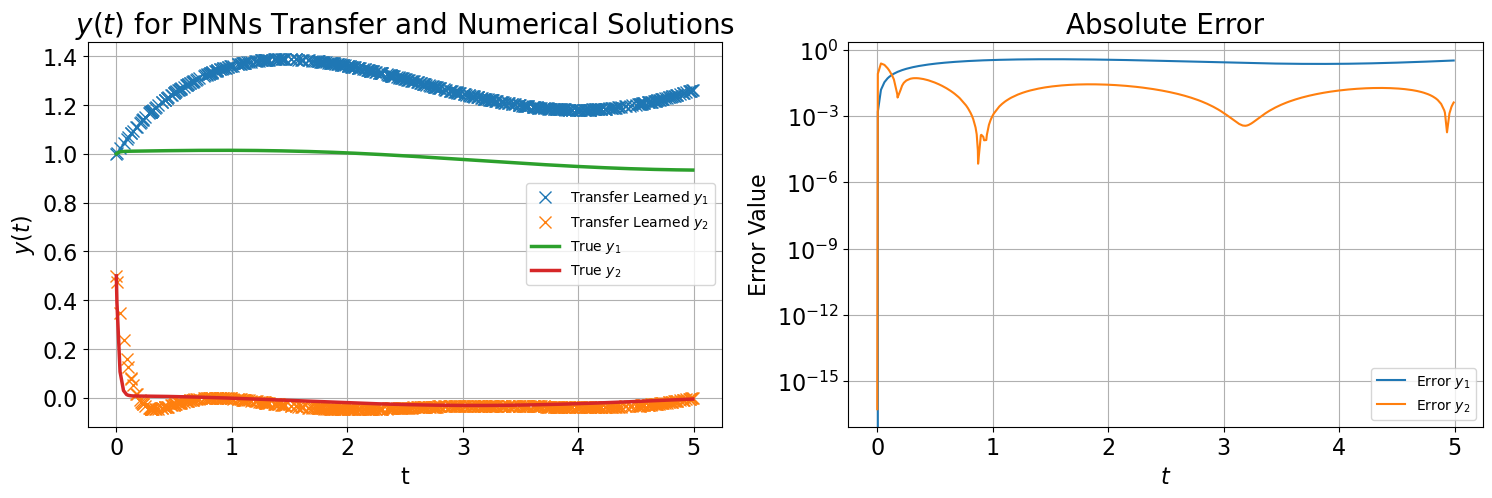

In [79]:
from src.utils_plot import plot_transfer_learned_and_analytical

rng = np.random.default_rng()
t_eval = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
t_eval = t_eval[np.concatenate(([0], rng.choice(range(1, len(t_eval)), size=512 - 1, replace=False)))]
t_eval = t_eval.reshape(-1, 1)
t_eval, _ = t_eval.sort(dim=0)

true_funct = lambda x: numerical_sol_fct(x, v=IC.detach().cpu().numpy(), alpha=alpha_transfer, beta=beta)
plot_transfer_learned_and_analytical(H=None, W_out=model_transfer, t_eval=t_eval, v=IC, A=None, force=None,
                                     num_equations=num_equations, true_funct=true_funct, reparametrization=reparametrization)